# Settings & Pointers

In [10]:
service_account_path = 'creds/google__sa.json'
DELIVERY_SHEET_ID = '1eUif5I8xhHU8fY0X9v8r2JI9hWPh7Dq_9VXpSIHwww4'
destination_folder_url = "https://drive.google.com/drive/folders/1b3UuMfgwxpOsW0GnsdsrEBWdjUvg8Ub7"
BATCH_NAME = "Batch 2"

# Download the delivered batch sheet

In [2]:
import pandas as pd
from google.oauth2 import service_account
from googleapiclient.discovery import build

def download_sheet_as_df(service_account_path, sheet_id, sheet_name):
    # Authenticate with the service account
    scopes = ['https://www.googleapis.com/auth/spreadsheets.readonly']
    creds = service_account.Credentials.from_service_account_file(
        service_account_path, scopes=scopes)
    service = build('sheets', 'v4', credentials=creds)

    # Construct the range to read
    sheet_range = f"{sheet_name}!A:Z"  # Adjust the range A:Z as needed

    # Make the API request
    result = service.spreadsheets().values().get(
        spreadsheetId=sheet_id, range=sheet_range).execute()
    values = result.get('values', [])

    # Convert to a DataFrame
    if not values:
        print("No data found.")
        return pd.DataFrame()
    else:
        return pd.DataFrame(values[1:], columns=values[0])

# Usage Example
sheet_name = BATCH_NAME
df = download_sheet_as_df(service_account_path, DELIVERY_SHEET_ID, sheet_name)
df

,task_link,metadata__topic,duration_mins,number_of_turns
0,https://colab.research.google.com/drive/1OUG8-...,python_language_and_scripting > object_oriente...,5,2
1,https://colab.research.google.com/drive/1YZIwQ...,python_language_and_scripting > modules_and_pa...,15,1
2,https://colab.research.google.com/drive/1xJxUj...,python_language_and_scripting > metaclasses_an...,15,2
3,https://colab.research.google.com/drive/1vkH0f...,unit_testing_methodology > best_practices_in_w...,8,1
4,https://colab.research.google.com/drive/19p4Jl...,unit_testing_methodology > unit_testing_basics,65,2
...,...,...,...,...
444,https://colab.research.google.com/drive/1AvI0u...,deep_learning > recurrent_neural_networks,45,5
445,https://colab.research.google.com/drive/1zYvJa...,unit_testing_methodology > mocking_and_patching,20,2
446,https://colab.research.google.com/drive/1zCB3E...,algorithms > by_topic > counting,,1
447,https://colab.research.google.com/drive/16dCMc...,unit_testing_methodology > test_driven_develop...,15,1


# Download and convert to messages

In [3]:
import io
import threading

import nbformat
from fuzzywuzzy import fuzz

from google.oauth2 import service_account
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload


def get_closest_match(query, choices):
    """
    Get the closest match(es) to a query string from a list of choices.

    :param query: The query string.
    :param choices: A list of strings to match against.
    :param limit: The maximum number of matches to return.
    """
    best_role = None
    best_score = 0
    for choice in choices:
        score = fuzz.ratio(query, choice)
        if score > best_score and score > 25:
            best_score = score
            best_role = choice

    return best_role, best_score


def notebook_parser(notebook):
    """
    Parse a notebook and extract the message objects.

    :param notebook: The notebook object.
    """
    messages = []
    for cell in notebook.cells[2:]:
        if cell["cell_type"] == "markdown":
            markdown_headers = ["**User**", "**Assistant**"]
            lines = cell["source"].split("\n")
            first_line = lines[0]
            role, score = get_closest_match(first_line, markdown_headers)
            if score>25:
                message = {
                    "role": role.replace("*", "").strip(),
                    "content": "\n".join(lines[1:]).strip("\n"),
                    "type": "markdown"
                }
                messages.append(message)

        elif cell["cell_type"] == "code":
            code_headers = ["# User", "# Assistant"]
            lines = cell["source"].split("\n")
            first_line = lines[0]
            role, score = get_closest_match(first_line, code_headers)
            if score>25:
                message = {
                    "role": role.replace("#", "").strip(),
                    "content": "\n".join(lines[1:]).strip("\n"),
                    "type": "code"
                }
                messages.append(message)
    return messages


def download_and_parse_notebook(service_account_file, file_id):
    # Authenticate with the service account
    credentials = service_account.Credentials.from_service_account_file(
        service_account_file, scopes=['https://www.googleapis.com/auth/drive'])
    service = build('drive', 'v3', credentials=credentials)

    # Request to download the file
    request = service.files().get_media(fileId=file_id)
    fh = io.BytesIO()
    downloader = MediaIoBaseDownload(fh, request)

    # Download the file
    done = False
    while not done:
        status, done = downloader.next_chunk()
        print("Download progress: %d%%." % int(status.progress() * 100))

    # Move the buffer's pointer to the beginning
    fh.seek(0)

    # Open the notebook
    notebook = nbformat.read(fh, as_version=4)

    # Parse the notebook
    messages = notebook_parser(notebook)

    # # Extract the first cell
    first_cell = notebook.cells[0]
    lines = first_cell["source"].split("\n")
    metadata = {}
    for line in lines:
        if "**Python Topics**" in line:
            metadata["topic"] = line.split(" - ")[1]
        if "**Type**" in line:
            metadata["type"] = line.split(" - ")[1]
        if "**Target Number of Turns (User + Assistant)**" in line:
            metadata["target_turns"] = line.split(" - ")[1]

    return {
        "id": file_id,
        "metadata": metadata,
        "messages":messages
    }


def threading_processor(service_account_path, file_id, results):
    results.append(download_and_parse_notebook(service_account_path, file_id))



threads = []
parsed_conversations = []
for i in range(len(df)):
    file_id = df["task_link"][i].split("/")[-1]
    thread = threading.Thread(target=threading_processor, args=(service_account_path, file_id, parsed_conversations))
    threads.append(thread)
    thread.start()

for thread in threads:
    thread.join()


Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.


In [4]:
parsed_conversations[0]

{'id': '1OUG8-T03DOGfWUo_Z_evplOAePcr1DVi',
 'metadata': {'topic': 'python_language_and_scripting > object_oriented_programming',
  'type': 'query',
  'target_turns': '2'},
 'messages': [{'role': 'User',
   'content': 'Can you show me how to define a simple Python class with an initializer that takes a name and age?',
   'type': 'markdown'},
  {'role': 'Assistant',
   'content': "Hey there, if you're looking to set up a simple Python class with a name and age then you can check out `__init__` method. It's like the setup guy, grabbing name and age and tagging them as `self.name` and `self.age`. Now, to check the attributes in the defined class instance, you may try out with `__dict__`. It's kinda easy to use. Easy peasy!",
   'type': 'markdown'},
  {'role': 'Assistant',
   'content': 'class Person:\n  def __init__(self, name: str, age: str):\n    self.name = name\n    self.age = age\n\n# Let\'s look at how the function is used in an example.\n# Create a Person class instance\nperson = P

In [7]:
count_valid = 0
count_invalid = 0
invalid_roles = []
for conversation in parsed_conversations:
    for message in conversation["messages"]:
        if message["role"] in ["User", "Assistant"]:
            count_valid += 1
        else:
            count_invalid += 1
            invalid_roles.append(message["role"])

print(f"Valid messages: {count_valid}")
print(f"Invalid messages: {count_invalid}")

Valid messages: 2548
Invalid messages: 0


In [8]:
import os
os.mkdir("jsonl_conversations/Batch 2")

In [9]:
import json

for i, conversation in enumerate(parsed_conversations):
    drive_id = conversation["id"] 
    messages = conversation["messages"]
    with open(f"jsonl_conversations/{BATCH_NAME}/{drive_id}.jsonl", "w") as f:
        for message in messages:
            f.write(json.dumps(message) + "\n")

In [11]:
from src.gdrive_api import build_service
from src.gdrive_api.folder_upload import upload_folder

service_account_path = 'creds/google__sa.json'
service = build_service(service_account_path)
uploaded_files = upload_folder(service, f'jsonl_conversations/{BATCH_NAME}/', destination_folder_url, force_replace = True, is_url=True)
uploaded_files

------------------------------------------------------------
Processing directory .: 1 of 0 in total.
Uploading file 1 of 446 in '.', 1 of 446 in total.
Uploading new file '1fG7t2doNzsWRMcgVXgk5to4Aa-v_Qppy.jsonl'.
File '1fG7t2doNzsWRMcgVXgk5to4Aa-v_Qppy.jsonl' has been uploaded.
Uploaded '1fG7t2doNzsWRMcgVXgk5to4Aa-v_Qppy.jsonl' to folder ID '1b3UuMfgwxpOsW0GnsdsrEBWdjUvg8Ub7'.
1fG7t2doNzsWRMcgVXgk5to4Aa-v_Qppy.jsonl
Uploading file 2 of 446 in '.', 2 of 446 in total.
Uploading new file '1esbLEwWk02b59ceVSIdNaQHiHhsBsMhS.jsonl'.
File '1esbLEwWk02b59ceVSIdNaQHiHhsBsMhS.jsonl' has been uploaded.
Uploaded '1esbLEwWk02b59ceVSIdNaQHiHhsBsMhS.jsonl' to folder ID '1b3UuMfgwxpOsW0GnsdsrEBWdjUvg8Ub7'.
1esbLEwWk02b59ceVSIdNaQHiHhsBsMhS.jsonl
Uploading file 3 of 446 in '.', 3 of 446 in total.
Uploading new file '1KwHzEamkWh5Go3rB5Aja26RVZwinhKkz.jsonl'.
File '1KwHzEamkWh5Go3rB5Aja26RVZwinhKkz.jsonl' has been uploaded.
Uploaded '1KwHzEamkWh5Go3rB5Aja26RVZwinhKkz.jsonl' to folder ID '1b3UuMfgwxpOsW

{'1fG7t2doNzsWRMcgVXgk5to4Aa-v_Qppy.jsonl': 'https://drive.google.com/uc?id=1ix2Fjnq6z7RIvrby46tMzEwP_MWIP0P2',
 '1esbLEwWk02b59ceVSIdNaQHiHhsBsMhS.jsonl': 'https://drive.google.com/uc?id=1A2YAwKnxqsPTyfAeuyXdeUuxHCp2FKBY',
 '1KwHzEamkWh5Go3rB5Aja26RVZwinhKkz.jsonl': 'https://drive.google.com/uc?id=1X0nYMpb4Ny9qoiKlK8yus7cyzkX-cev1',
 '1onBf9GjTqF8ZfhmVsBhEH3NkLUIcilfB.jsonl': 'https://drive.google.com/uc?id=1eWv7EuR2C5Z_pWGYgRu-ewKUOmCffZWM',
 '1Q1N6KeQlynG8qHhNqhW8Nutuy-tH4i9S.jsonl': 'https://drive.google.com/uc?id=1nX30JnDk8AcdbTem3yIrwFn9GGz2CgeN',
 '1r4isdE_46L6bMdEpRcs4GMcLInUN6G98.jsonl': 'https://drive.google.com/uc?id=14gnPb78YC7HTo9RDOEbPGiwcG6Wgy1jR',
 '1oJ5Bvt1zgtqoTt1r46-cQYhU-C8YGc92.jsonl': 'https://drive.google.com/uc?id=1pcnwqoebbXG4Ajm1VNGifralLEj3DRrr',
 '18OoTGhJ7GilsEqQMsm_O8nBh11T26ctE.jsonl': 'https://drive.google.com/uc?id=1rMFN1z9Sq0tBgwYD1QqijPos-mpjkplj',
 '18nGceaLSmhy3MsEMTL9UTFyGjJ3CeZ3y.jsonl': 'https://drive.google.com/uc?id=10tQj-N896SMNz8SNwlnnnZ4pxGa

# Inspect the jsonl google drive folder to list file_names vs drive links

In [12]:
from google.oauth2 import service_account
from googleapiclient.discovery import build

# Path to your service account JSON key file
SERVICE_ACCOUNT_FILE = 'creds/google__sa.json'

# Define the scopes
SCOPES = ['https://www.googleapis.com/auth/drive']

# Authenticate and create the service
credentials = service_account.Credentials.from_service_account_file(
        SERVICE_ACCOUNT_FILE, scopes=SCOPES)

service = build('drive', 'v3', credentials=credentials)

# Replace with your Google Drive folder ID
folder_id = destination_folder_url.split("/")[-1]

# Query to get files from the folder
query = f"'{folder_id}' in parents"

# Specify the page size
page_size = 1000  # You can change this number as needed

# Initialize page token
page_token = None


all_files = []
# Loop through pages of results
while True:
    response = service.files().list(q=query,
                                    spaces='drive',
                                    fields='nextPageToken, files(id, name, webViewLink)',
                                    pageSize=page_size,
                                    pageToken=page_token).execute()

    # Print file names and URLs
    for file in response.get('files', []):
        all_files.append(file)
        print('Found file: %s (%s) %s' % (file.get('name'), file.get('id'), file.get('webViewLink')))

    # Update the page token
    page_token = response.get('nextPageToken', None)
    if page_token is None:
        break

Found file: 1vsafizt-tYIezgVAfSTuSb2rYWYHPwlp.jsonl (15XR_wgpqEgjKNtu9ofaLnvVs42CRyziS) https://drive.google.com/file/d/15XR_wgpqEgjKNtu9ofaLnvVs42CRyziS/view?usp=drivesdk
Found file: 1Wi4cemYSKn7h6IaiFsgLwBaEgUrFCJWP.jsonl (1Ss_Knq1qaixwfF39D-KuoFm-aId7mDb9) https://drive.google.com/file/d/1Ss_Knq1qaixwfF39D-KuoFm-aId7mDb9/view?usp=drivesdk
Found file: 15eCpkW9bc1l3YYZdfx1PgSqhNNYgyHG-.jsonl (1K7a0Hcwkdf_3ouNj3SG_9R3CgRm6p9A_) https://drive.google.com/file/d/1K7a0Hcwkdf_3ouNj3SG_9R3CgRm6p9A_/view?usp=drivesdk
Found file: 1Hx8GGLu5Q2s2mzZSXfBxilvO75icCCTt.jsonl (1aAgT5k4uqGYLYlDGe45i4who2Nu0DvrG) https://drive.google.com/file/d/1aAgT5k4uqGYLYlDGe45i4who2Nu0DvrG/view?usp=drivesdk
Found file: 1tdFCt54v02FkvEDdpGdSvyNr0wLvECrX.jsonl (1ftcIxEnytjqCShMugVK03w0bUZYhGtcM) https://drive.google.com/file/d/1ftcIxEnytjqCShMugVK03w0bUZYhGtcM/view?usp=drivesdk
Found file: 1vkH0fqhw3MaAYQ6Q6PLufwc8Soi--fUO.jsonl (19OxWvBZ9VXE8mo8AuUc7OfreiWdz7Jjx) https://drive.google.com/file/d/19OxWvBZ9VXE8mo8AuUc

In [13]:
jsonl_df = pd.DataFrame(all_files)
jsonl_df

,webViewLink,id,name
0,https://drive.google.com/file/d/15XR_wgpqEgjKN...,15XR_wgpqEgjKNtu9ofaLnvVs42CRyziS,1vsafizt-tYIezgVAfSTuSb2rYWYHPwlp.jsonl
1,https://drive.google.com/file/d/1Ss_Knq1qaixwf...,1Ss_Knq1qaixwfF39D-KuoFm-aId7mDb9,1Wi4cemYSKn7h6IaiFsgLwBaEgUrFCJWP.jsonl
2,https://drive.google.com/file/d/1K7a0Hcwkdf_3o...,1K7a0Hcwkdf_3ouNj3SG_9R3CgRm6p9A_,15eCpkW9bc1l3YYZdfx1PgSqhNNYgyHG-.jsonl
3,https://drive.google.com/file/d/1aAgT5k4uqGYLY...,1aAgT5k4uqGYLYlDGe45i4who2Nu0DvrG,1Hx8GGLu5Q2s2mzZSXfBxilvO75icCCTt.jsonl
4,https://drive.google.com/file/d/1ftcIxEnytjqCS...,1ftcIxEnytjqCShMugVK03w0bUZYhGtcM,1tdFCt54v02FkvEDdpGdSvyNr0wLvECrX.jsonl
...,...,...,...
441,https://drive.google.com/file/d/1nX30JnDk8Acdb...,1nX30JnDk8AcdbTem3yIrwFn9GGz2CgeN,1Q1N6KeQlynG8qHhNqhW8Nutuy-tH4i9S.jsonl
442,https://drive.google.com/file/d/1eWv7EuR2C5Z_p...,1eWv7EuR2C5Z_pWGYgRu-ewKUOmCffZWM,1onBf9GjTqF8ZfhmVsBhEH3NkLUIcilfB.jsonl
443,https://drive.google.com/file/d/1X0nYMpb4Ny9qo...,1X0nYMpb4Ny9qoiKlK8yus7cyzkX-cev1,1KwHzEamkWh5Go3rB5Aja26RVZwinhKkz.jsonl
444,https://drive.google.com/file/d/1A2YAwKnxqsPTy...,1A2YAwKnxqsPTyfAeuyXdeUuxHCp2FKBY,1esbLEwWk02b59ceVSIdNaQHiHhsBsMhS.jsonl


# Join to identify which jsonl belongs to which colab

In [14]:
df["colab_id"] = df["task_link"].apply(lambda x: x.split("/")[-1])
jsonl_df["colab_id"] = jsonl_df["name"].apply(lambda x: x.split(".")[0])


df_merged = df.merge(jsonl_df, on="colab_id", how="inner")
df_merged = df_merged[["task_link", "metadata__topic", "duration_mins", "number_of_turns", "webViewLink"]]
df_merged = df_merged.rename(columns={"webViewLink": "jsonl_link"})
df_merged

,task_link,metadata__topic,duration_mins,number_of_turns,jsonl_link
0,https://colab.research.google.com/drive/1OUG8-...,python_language_and_scripting > object_oriente...,5,2,https://drive.google.com/file/d/1LLaj8_n2kLiTy...
1,https://colab.research.google.com/drive/1YZIwQ...,python_language_and_scripting > modules_and_pa...,15,1,https://drive.google.com/file/d/1jCUujR6N_tPo0...
2,https://colab.research.google.com/drive/1xJxUj...,python_language_and_scripting > metaclasses_an...,15,2,https://drive.google.com/file/d/1ovneRS0Tqk0d4...
3,https://colab.research.google.com/drive/1vkH0f...,unit_testing_methodology > best_practices_in_w...,8,1,https://drive.google.com/file/d/19OxWvBZ9VXE8m...
4,https://colab.research.google.com/drive/19p4Jl...,unit_testing_methodology > unit_testing_basics,65,2,https://drive.google.com/file/d/14riyc6l8KNKBH...
...,...,...,...,...,...
444,https://colab.research.google.com/drive/1AvI0u...,deep_learning > recurrent_neural_networks,45,5,https://drive.google.com/file/d/1_zss_HiWU4Gly...
445,https://colab.research.google.com/drive/1zYvJa...,unit_testing_methodology > mocking_and_patching,20,2,https://drive.google.com/file/d/19-DCIq6ghlAK2...
446,https://colab.research.google.com/drive/1zCB3E...,algorithms > by_topic > counting,,1,https://drive.google.com/file/d/1yz4I6idfCrjZL...
447,https://colab.research.google.com/drive/16dCMc...,unit_testing_methodology > test_driven_develop...,15,1,https://drive.google.com/file/d/1tRW-kjgvie6EL...


In [21]:
from src.sheets_utils import upload_df_to_sheet

cols = ["task_link", "jsonl_link", "metadata__topic", "duration_mins", "number_of_turns"]
upload_df_to_sheet(service_account_path, DELIVERY_SHEET_ID, "Batch 2", df_merged[cols])

In [20]:
df_merged["metadata__topic"] = df_merged["metadata__topic"].apply(lambda x: x.replace("Python Topics - ", ""))
df_merged["toplevel_topic"] = df_merged["metadata__topic"].apply(lambda x: x.split(" > ")[0])
df_merged

,task_link,metadata__topic,duration_mins,number_of_turns,jsonl_link,toplevel_topic
0,https://colab.research.google.com/drive/1OUG8-...,python_language_and_scripting > object_oriente...,5,2,https://drive.google.com/file/d/1LLaj8_n2kLiTy...,python_language_and_scripting
1,https://colab.research.google.com/drive/1YZIwQ...,python_language_and_scripting > modules_and_pa...,15,1,https://drive.google.com/file/d/1jCUujR6N_tPo0...,python_language_and_scripting
2,https://colab.research.google.com/drive/1xJxUj...,python_language_and_scripting > metaclasses_an...,15,2,https://drive.google.com/file/d/1ovneRS0Tqk0d4...,python_language_and_scripting
3,https://colab.research.google.com/drive/1vkH0f...,unit_testing_methodology > best_practices_in_w...,8,1,https://drive.google.com/file/d/19OxWvBZ9VXE8m...,unit_testing_methodology
4,https://colab.research.google.com/drive/19p4Jl...,unit_testing_methodology > unit_testing_basics,65,2,https://drive.google.com/file/d/14riyc6l8KNKBH...,unit_testing_methodology
...,...,...,...,...,...,...
444,https://colab.research.google.com/drive/1AvI0u...,deep_learning > recurrent_neural_networks,45,5,https://drive.google.com/file/d/1_zss_HiWU4Gly...,deep_learning
445,https://colab.research.google.com/drive/1zYvJa...,unit_testing_methodology > mocking_and_patching,20,2,https://drive.google.com/file/d/19-DCIq6ghlAK2...,unit_testing_methodology
446,https://colab.research.google.com/drive/1zCB3E...,algorithms > by_topic > counting,,1,https://drive.google.com/file/d/1yz4I6idfCrjZL...,algorithms
447,https://colab.research.google.com/drive/16dCMc...,unit_testing_methodology > test_driven_develop...,15,1,https://drive.google.com/file/d/1tRW-kjgvie6EL...,unit_testing_methodology


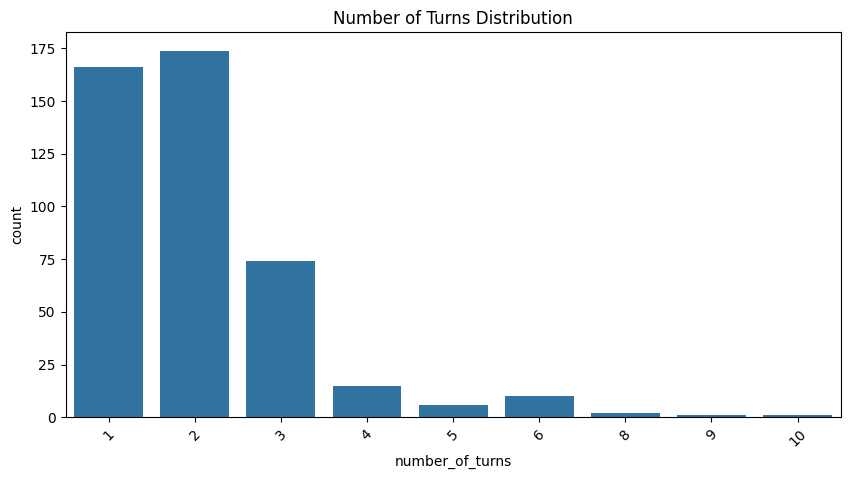

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.countplot(data=df_merged, x="number_of_turns", order=df_merged["number_of_turns"].value_counts().index.astype(int).sort_values())
plt.xticks(rotation=45)
plt.title("Number of Turns Distribution")
plt.show()

In [36]:
def clean_topic(topic):
    topic = topic.lower()
    topic = topic.replace("python topics - ", "")
    topic = topic.strip()
    return topic

df_merged["toplevel_topic"] = df_merged["toplevel_topic"].apply(clean_topic)
df_merged["toplevel_topic"].value_counts()

toplevel_topic
python_language_and_scripting    140
algorithms                       116
unit_testing_methodology          65
data_analysis                     27
web_development                   25
ml_principles                     24
deep_learning                     15
database                          13
                                  10
debugging_and_tracing              6
high_school                        6
everyday_use_cases                 1
by_topic                           1
Name: count, dtype: int64

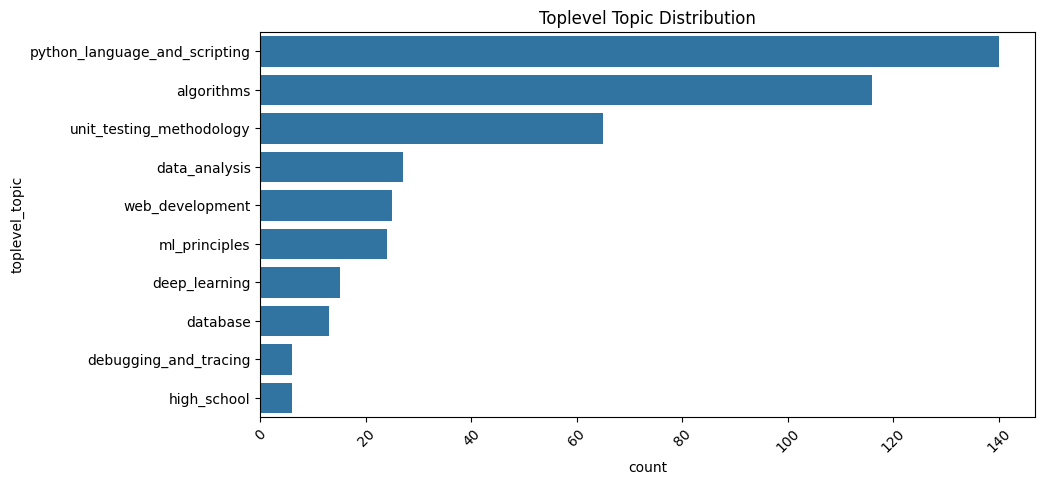

In [39]:
# Visualize toplevel_topic, sort x-axis by more frequent topics
plt.figure(figsize=(10, 5))
sns.countplot(data=df_merged, y="toplevel_topic", order=df_merged[~df_merged["toplevel_topic"].isin(["", "by_topic", "everyday_use_cases"])]["toplevel_topic"].value_counts().index)
plt.xticks(rotation=45)
plt.title("Toplevel Topic Distribution")
plt.show()